In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.portfolio_management.management import Management
from financial_common.portfolio_management.metrics import Metrics
from financial_common.risk.benchmark import Benchmark
import numpy as np

In [3]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [4]:
## Database Declarations
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")

In [6]:
## Retrieve and set up factors for modeling

## Feel free to add additional tickers you would like to use for modeling
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.lower_column(market.query("prices",{"ticker":ticker}))
        price = p.utc_date(price)
        price.sort_values("date")
        price["adjclose"] = price["adjclose"].shift(60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.23it/s]


In [7]:
## Defining years for modeling and backtesting feel free to change these
model_start = 2015
model_end = 2022
backtest_end = 2026

In [8]:
market.connect()
prices = []

for ticker in tqdm(index["ticker"][:100]): 
    try:
        ## price prep
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            ## factor merge and indicator calculations
            price = factors_df.merge(price[["date", "ticker", "adjclose", "adjhigh", "adjlow", "adjvolume"]], on="date", how="left")
            price = p.additional_date_columns(price)
            price = Indicator.calculate_indicators(price)
            
            price["y"] = price["adjclose"].shift(-60)
    
            ## subsetting training and modeling data
            training_data = price[(price["year"] >= model_start) & (price["year"] < model_end)].dropna(subset=factors).dropna()
            sim = price[(price["year"] >= model_end - 1) & (price["year"] < backtest_end)].dropna(subset=factors)
            if training_data.index.size >200 and sim.index.size >200:
                ## Modeling and Projections
                model = XGBRegressor()
                model.fit(training_data[factors], training_data["y"])
                sim["prediction"] = model.predict(sim[factors])
        
                ## Risk Application
                sim = sim.merge(macro, on="date", how="left")
                sim = SingleIndexCAPM.apply(sim)
                
                prices.append(sim)
    except Exception as e:
        # Print the exception message for debugging, continue processing the next ticker
        print(str(e))
        continue

market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


In [9]:
## getting names
simulation = pd.concat(prices).merge(index[["ticker","name"]],on="ticker",how="left")

## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.columns

Index(['date', 'AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA',
       'ticker', 'adjclose', 'adjhigh', 'adjlow', 'adjvolume', 'year', 'month',
       'quarter', 'week', 'reference_price', 'reference_volume',
       'reference_high', 'reference_low', 'rolling_dollar_volume', 'adr',
       'sma', 'ema', 'std', 'bollinger_upper', 'bollinger_lower', 'pct_change',
       'coev', 'atr', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'rogan', 'y', 'realtime_start', 'realtime_end', 'rf',
       'factor', 'risk', 'sigma', 'name', 'sell_price', 'sell_date'],
      dtype='object')

In [10]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [11]:
run = True
if run:
    analysises = []
    for ascending in [True,False]:
        for position_type in tqdm(["long","short"]):
            for selection_type in tqdm(["top","mixed","bottom"]):
                for stocks_per_group in [.1,.5]:
                    try:
                        parameters = {
                            "ascending":ascending,
                            "position_type":position_type,
                            "selection_type":selection_type,
                            "stocks_per_group": stocks_per_group
                        }
                        pm = Management("quarter","factor",position_type,ascending,selection_type,stocks_per_group,"rolling_dollar_volume")
                        trades = pm.trades(simulation.copy())
                        portfolio = pm.portfolio(trades.copy(),benchmark.copy())
                        metrics = Metrics.performance(trades,portfolio)
                        analysises.append({**parameters.copy(),**metrics.copy()})
                    except Exception as e:
                        print(str(e))
                        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


In [12]:
a = pd.DataFrame(analysises)

In [22]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

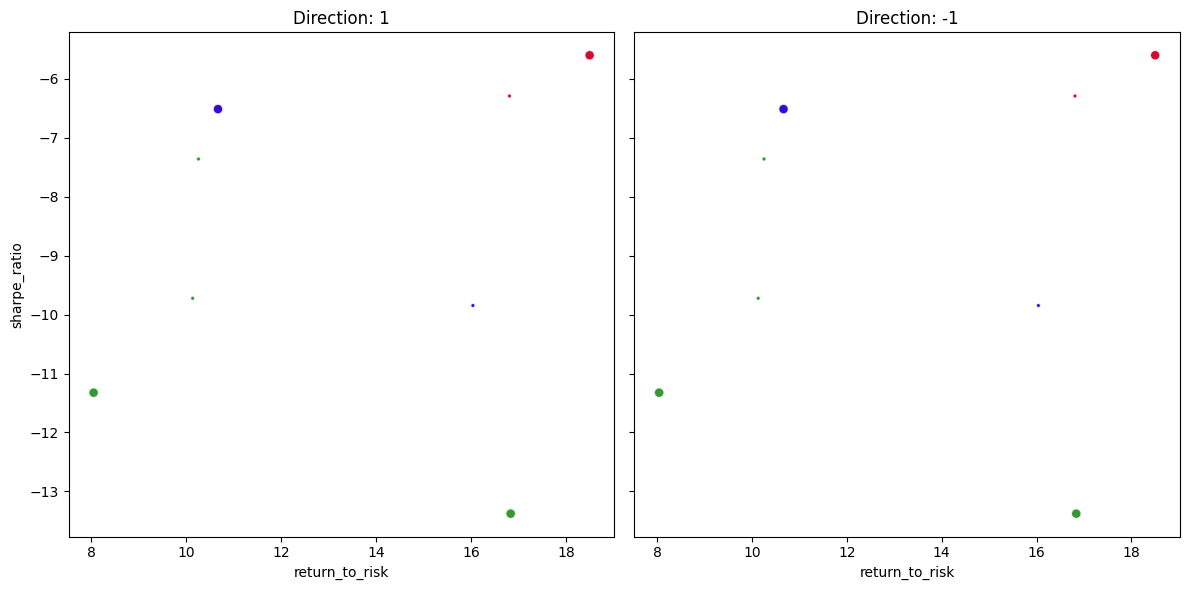

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["return_to_risk"],
        d_analysis["sharpe_ratio"],
        c=d_analysis["color"],
        s=d_analysis["stocks_per_group"] * 100,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [24]:
a.sort_values("pnl",ascending=False).head(20)

,ascending,position_type,selection_type,stocks_per_group,date,pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,color,return_to_risk
7,True,short,top,0.5,2025-03-20 00:00:00+00:00,1.462884,0.902058,0.043731,0.079067,1.170204,0.853402,0.563218,1.031831,-5.600572,blue,18.501790
23,False,short,bottom,0.5,2025-03-20 00:00:00+00:00,1.462884,0.902058,0.043731,0.079067,1.170204,0.853402,0.563218,1.031831,-5.600572,red,18.501790
22,False,short,bottom,0.1,2025-03-20 00:00:00+00:00,1.386713,0.883725,0.056739,0.082490,1.163594,0.858001,0.557047,1.028230,-6.291576,red,16.810668
6,True,short,top,0.1,2025-03-20 00:00:00+00:00,1.386713,0.883725,0.056739,0.082490,1.163594,0.858001,0.557047,1.028230,-6.291576,blue,16.810668
19,False,short,top,0.5,2025-03-20 00:00:00+00:00,1.183161,0.810670,0.075766,0.110919,1.154234,0.850918,0.540230,1.014778,-6.514166,blue,10.666897
11,True,short,bottom,0.5,2025-03-20 00:00:00+00:00,1.183161,0.810670,0.075766,0.110919,1.154234,0.850918,0.540230,1.014778,-6.514166,red,10.666897
10,True,short,bottom,0.1,2025-03-20 00:00:00+00:00,1.180832,0.858244,0.049660,0.073619,1.130969,0.870959,0.546980,1.013179,-9.846353,red,16.039882
18,False,short,top,0.1,2025-03-20 00:00:00+00:00,1.180832,0.858244,0.049660,0.073619,1.130969,0.870959,0.546980,1.013179,-9.846353,blue,16.039882
8,True,short,mixed,0.1,2025-03-20 00:00:00+00:00,1.109449,0.759844,0.093012,0.108178,1.156587,0.835471,0.546980,1.011115,-7.360623,green,10.255782
2,True,long,mixed,0.1,2025-03-20 00:00:00+00:00,1.109449,0.759844,0.093012,0.108178,1.156587,0.835471,0.546980,1.011115,-7.360623,green,10.255782


In [16]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'ascending': True,
 'position_type': 'short',
 'selection_type': 'top',
 'stocks_per_group': 0.5,
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 1.462884423082511,
 'downside': 0.9020583457436566,
 'coefficient_of_variation': 0.043730637880752064,
 'portfolio_std': 0.07906718216413229,
 'average_gain': 1.1702037926201734,
 'average_loss': 0.853401799345124,
 'win_loss_ratio': 0.5632183908045977,
 'weekly_return': 1.0318305082011863,
 'sharpe_ratio': -5.600572408416221,
 'color': 'green',
 'return_to_risk': 18.501790288235767}

In [17]:
pm = Management("quarter","factor",top["position_type"],top["ascending"],top["selection_type"],top["stocks_per_group"],"rolling_dollar_volume")
trades = pm.trades(simulation.copy()).merge(index[["ticker","name"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

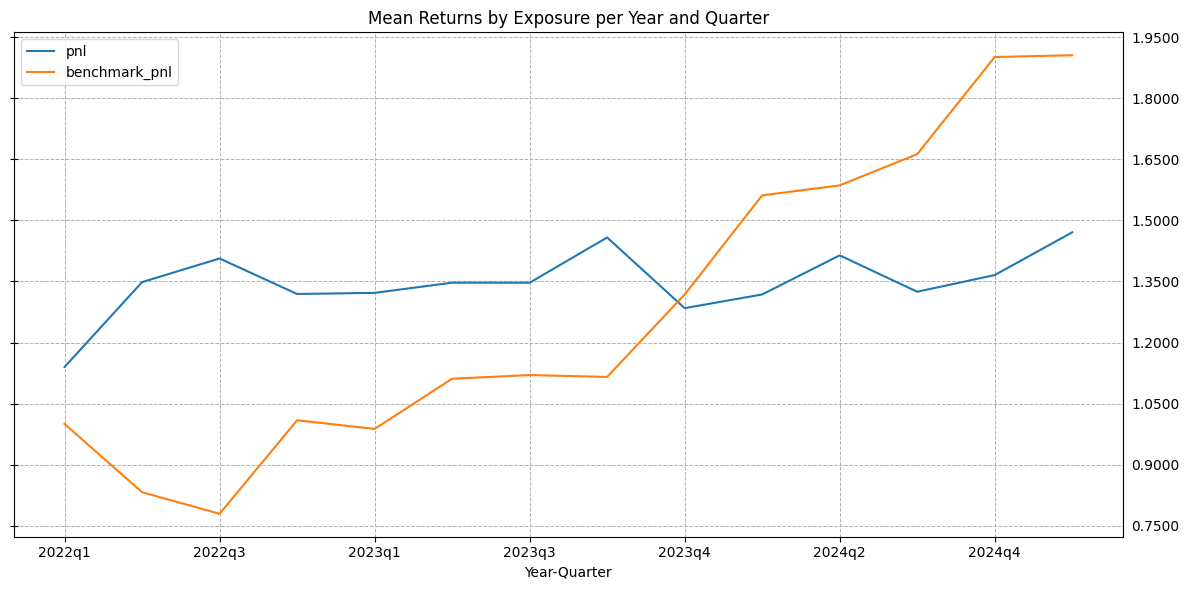

In [18]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
portfolio.tail()

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Quarter
9,2024-03-28 00:00:00+00:00,1.026194,1.318041,195.836224,1.561467,2024,3,1,13,2024q1
10,2024-06-28 00:00:00+00:00,1.072888,1.414110,198.914903,1.586014,2024,6,2,26,2024q2
11,2024-09-30 00:00:00+00:00,0.936800,1.324738,208.537174,1.662736,2024,9,3,40,2024q3
12,2024-12-31 00:00:00+00:00,1.030892,1.365662,238.472340,1.901419,2024,12,4,1,2024q4
13,2025-03-20 00:00:00+00:00,1.076926,1.470717,239.010000,1.905706,2025,3,1,12,2025q1


In [20]:
trades.sort_values("return",ascending=False)

,ticker,date,adjclose,sell_price,factor,adr,sma,ema,bollinger_upper,bollinger_lower,...,rogan,y,factor_rank,asset_type,return,name,year,month,quarter,week
250,ACET,2023-09-29 00:00:00+00:00,2.730000,1.370000,-153.643350,0.080147,2.557840,2.683587,3.664579,1.451100,...,4.574319e+06,0.501832,0.926471,-1.0,1.407865,"Adicet Bio, Inc. Common Stock",2023,9,3,39
251,ADCT,2023-09-29 00:00:00+00:00,2.150000,0.897000,-50.787913,0.064453,1.204047,1.265533,1.914167,0.493926,...,-3.074477e+06,0.417209,0.911765,-1.0,1.407865,ADC Therapeutics SA,2023,9,3,39
247,ADIL,2023-09-29 00:00:00+00:00,5.170000,2.779900,-977.774640,0.126861,1.616225,1.521768,2.330097,0.902352,...,9.047423e+05,0.537698,0.970588,-1.0,1.407865,"Adial Pharmaceuticals, Inc",2023,9,3,39
232,AAP,2023-06-30 00:00:00+00:00,117.411741,68.094387,0.401685,0.025560,1.188888,1.180016,1.438821,0.938956,...,3.003072e+06,0.579962,0.338235,-1.0,1.407865,ADVANCE AUTO PARTS INC,2023,6,2,26
285,ADTX,2023-12-29 00:00:00+00:00,119400.000000,66300.000000,-233922.828523,0.142370,1.564897,1.983247,2.644536,0.485257,...,6.090415e+04,0.555276,1.000000,-1.0,1.407865,"Aditxt, Inc. Common Stock",2023,12,4,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,ADMA,2022-12-30 00:00:00+00:00,2.500000,3.880000,0.080876,0.063872,0.923909,0.941601,1.173218,0.674601,...,2.778070e+07,1.552000,0.617647,-1.0,0.633814,"ADMA Biologics, Inc.",2022,12,4,52
487,AAL,2024-12-31 00:00:00+00:00,10.900000,17.430000,-2.984308,0.030475,1.004395,1.009425,1.251218,0.757572,...,2.373383e+08,1.599083,0.808824,-1.0,0.633814,American Airlines Group Inc.,2024,12,4,1
501,ACCD,2025-03-20 00:00:00+00:00,3.420000,6.990000,-45.053055,0.051646,1.095936,1.164695,1.291980,0.899891,...,-4.251210e+06,2.043860,0.911765,-1.0,0.633814,"Accolade, Inc. Common Stock",2025,3,1,12
516,ACMR,2025-03-20 00:00:00+00:00,15.570000,27.500000,-1.757948,0.048214,1.196212,1.198742,1.456581,0.935843,...,3.787557e+06,1.766217,0.794118,-1.0,0.633814,"ACM Research, Inc. Class A Common Stock",2025,3,1,12
